# CKME 136 - Capstone Project [Farrukh Aziz]

## 1 - Loading Yelp Dataset
Import required libraries

> For some of the thirs party libraries, you may have to run 'pip install' commands
> e.g.
>
> - *pip install geopy*
> - *pip install shaply*
> - *pip install matplotlib*
> - *pip install plotly*
> - *pip install cufflinks*


In [3]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time, plotly.plotly as py, plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from collections import Counter
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
%matplotlib inline

Read data from the file and analyze attributes
> The following files from Yelp Dataset will be used:
> 1. **yelp_academic_dataset_business.json** : Business location coordinates, locations and categories etc.
> 2. **yelp_academic_dataset_review.json** : User reviews, related business ids etc.
>
> Rest of the data from the dataset is not useful for the purposes of this project.

In [4]:
business_file = "yelp_academic_dataset_business.json"
review_file = "yelp_academic_dataset_review.json"

start_time = time.time()

df_business_data_full = pd.read_json(business_file, lines=True)
df_review_data_full = pd.read_json(review_file, lines=True)

print('Time taken: {:,.2f} seconds'.format(time.time()-start_time))


Time taken: 71.98 seconds


---
Reveal datatypes and sample data rows from the DataSet

*1. **Business** data datatypes and attributes*

In [6]:
df_business_data_full.info()
df_business_data_full.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188593 entries, 0 to 188592
Data columns (total 15 columns):
address         188593 non-null object
attributes      162807 non-null object
business_id     188593 non-null object
categories      188052 non-null object
city            188593 non-null object
hours           143791 non-null object
is_open         188593 non-null int64
latitude        188587 non-null float64
longitude       188587 non-null float64
name            188593 non-null object
neighborhood    188593 non-null object
postal_code     188593 non-null object
review_count    188593 non-null int64
stars           188593 non-null float64
state           188593 non-null object
dtypes: float64(3), int64(2), object(10)
memory usage: 21.6+ MB


,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,1314 44 Avenue NE,"{'BikeParking': 'False', 'BusinessAcceptsCredi...",Apn5Q_b6Nz61Tq4XzPdf9A,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",Calgary,"{'Monday': '8:30-17:0', 'Tuesday': '11:0-21:0'...",1,51.091813,-114.031675,Minhas Micro Brewery,,T2E 6L6,24,4.0,AB
1,,"{'Alcohol': 'none', 'BikeParking': 'False', 'B...",AjEbIBw6ZFfln7ePHha9PA,"Chicken Wings, Burgers, Caterers, Street Vendo...",Henderson,"{'Friday': '17:0-23:0', 'Saturday': '17:0-23:0...",0,35.960734,-114.939821,CK'S BBQ & Catering,,89002,3,4.5,NV
2,1335 rue Beaubien E,"{'Alcohol': 'beer_and_wine', 'Ambience': '{'ro...",O8S5hYJ1SMc8fA4QBtVujA,"Breakfast & Brunch, Restaurants, French, Sandw...",Montréal,"{'Monday': '10:0-22:0', 'Tuesday': '10:0-22:0'...",0,45.540503,-73.599300,La Bastringue,Rosemont-La Petite-Patrie,H2G 1K7,5,4.0,QC


*2. **Review** data types and attributes*

In [7]:
df_review_data_full.info()
df_review_data_full.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5996996 entries, 0 to 5996995
Data columns (total 9 columns):
business_id    object
cool           int64
date           datetime64[ns]
funny          int64
review_id      object
stars          int64
text           object
useful         int64
user_id        object
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 411.8+ MB


,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,iCQpiavjjPzJ5_3gPD5Ebg,0,2011-02-25,0,x7mDIiDB3jEiPGPHOmDzyw,2,The pizza was okay. Not the best I've had. I p...,0,msQe1u7Z_XuqjGoqhB0J5g
1,pomGBqfbxcqPv14c3XH-ZQ,0,2012-11-13,0,dDl8zu1vWPdKGihJrwQbpw,5,I love this place! My fiance And I go here atl...,0,msQe1u7Z_XuqjGoqhB0J5g
2,jtQARsP6P-LbkyjbO1qNGg,1,2014-10-23,1,LZp4UX5zK3e-c5ZGSeo3kA,1,Terrible. Dry corn bread. Rib tips were all fa...,3,msQe1u7Z_XuqjGoqhB0J5g


---

## 2 - Attribute selection, cleanup and filtering of dataset

Reduce the attribute list to only the useful information for this project.
> * From business data, [ business_id, latitude, longitude, city, state, postal_code and categories ]
> * From review data, [ business_id, review_id, user_id ]

In [8]:
start_time = time.time()

business_cols = ['business_id', 'latitude', 'longitude', 'city', 'state', 'postal_code', 'stars', 'categories']
review_cols = ['business_id', 'review_id', 'user_id']

df_business_data = df_business_data_full.filter(business_cols , axis=1)
df_review_data = df_review_data_full.filter(review_cols , axis=1)

print('Time taken: {:,.2f} seconds'.format(time.time()-start_time))

df_business_data.head()


Time taken: 0.35 seconds


,business_id,latitude,longitude,city,state,postal_code,stars,categories
0,Apn5Q_b6Nz61Tq4XzPdf9A,51.091813,-114.031675,Calgary,AB,T2E 6L6,4.0,"Tours, Breweries, Pizza, Restaurants, Food, Ho..."
1,AjEbIBw6ZFfln7ePHha9PA,35.960734,-114.939821,Henderson,NV,89002,4.5,"Chicken Wings, Burgers, Caterers, Street Vendo..."
2,O8S5hYJ1SMc8fA4QBtVujA,45.540503,-73.599300,Montréal,QC,H2G 1K7,4.0,"Breakfast & Brunch, Restaurants, French, Sandw..."
3,bFzdJJ3wp3PZssNEsyU23g,33.449999,-112.076979,Phoenix,AZ,85003,1.5,"Insurance, Financial Services"
4,8USyCYqpScwiNEb58Bt6CA,51.035591,-114.027366,Calgary,AB,T2H 0N5,2.0,"Home & Garden, Nurseries & Gardening, Shopping..."


#### Prepare Business Data
For the scope of this project, filter down to the businesses located within US/Canada and the ones that have been categorized. This will eliminate noise and small number of restaurants that have not been categorized.
Limiting the data to US/Canada will help fit it within North American Map coordinates while retaining majority of the data.

*Note: Business categories could be inferred based on user reviews, however, that is outside the scope of this project*

In [9]:
start_time = time.time()

print(df_business_data.shape)

north_american_state_provinces = ['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NA', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV', 'WY','AB', 'BC', 'MB', 'NB', 'NL', 'NT', 'NS', 'NU', 'ON', 'PE', 'QC', 'SK', 'YT']

for idx, row in df_business_data.iterrows():
    if row['state'] not in north_american_state_provinces:
        df_business_data.drop(idx, inplace=True)

df_business_data = df_business_data[df_business_data['categories'].notnull()]

print(df_business_data.shape)

print('Time taken: {:,.2f} seconds'.format(time.time()-start_time))
df_business_data.head()

(188593, 8)
(187464, 8)
Time taken: 41.19 seconds


,business_id,latitude,longitude,city,state,postal_code,stars,categories
0,Apn5Q_b6Nz61Tq4XzPdf9A,51.091813,-114.031675,Calgary,AB,T2E 6L6,4.0,"Tours, Breweries, Pizza, Restaurants, Food, Ho..."
1,AjEbIBw6ZFfln7ePHha9PA,35.960734,-114.939821,Henderson,NV,89002,4.5,"Chicken Wings, Burgers, Caterers, Street Vendo..."
2,O8S5hYJ1SMc8fA4QBtVujA,45.540503,-73.599300,Montréal,QC,H2G 1K7,4.0,"Breakfast & Brunch, Restaurants, French, Sandw..."
3,bFzdJJ3wp3PZssNEsyU23g,33.449999,-112.076979,Phoenix,AZ,85003,1.5,"Insurance, Financial Services"
4,8USyCYqpScwiNEb58Bt6CA,51.035591,-114.027366,Calgary,AB,T2H 0N5,2.0,"Home & Garden, Nurseries & Gardening, Shopping..."


 Filter down to the list of businesses that are categorized as Restaurants
 > - Cleanup and build list of all categories
 > - Filter down to rows containing Restaurants as category
 > - Display number of rows before and after

In [10]:
start_time = time.time()

# create copy so that original business_data is intact
df_business_categorized_data = df_business_data.copy()

df_business_categorized_data['categories'] = df_business_data['categories'].map(lambda x : (list(map(str.strip, x.split(',')))))

print('Total data rows and columns:{}'.format(df_business_categorized_data.shape))

df_restaurants = df_business_categorized_data[df_business_categorized_data['categories'].map(lambda x : 'Restaurants' in x)]

print('Restaurant data rows and columns:{}'.format(df_restaurants.shape))

print('Time taken: {:,.2f} seconds'.format(time.time()-start_time))

Total data rows and columns:(187464, 8)
Restaurant data rows and columns:(56839, 8)
Time taken: 0.95 seconds


Since we have dropped all rows that don't have *Restaurant* as category, dataframe must be re-indexed to fill the gaps.

In [11]:
df_restaurants = df_restaurants.reset_index(drop=True)
df_restaurants.head()

,business_id,latitude,longitude,city,state,postal_code,stars,categories
0,Apn5Q_b6Nz61Tq4XzPdf9A,51.091813,-114.031675,Calgary,AB,T2E 6L6,4.0,"[Tours, Breweries, Pizza, Restaurants, Food, H..."
1,AjEbIBw6ZFfln7ePHha9PA,35.960734,-114.939821,Henderson,NV,89002,4.5,"[Chicken Wings, Burgers, Caterers, Street Vend..."
2,O8S5hYJ1SMc8fA4QBtVujA,45.540503,-73.599300,Montréal,QC,H2G 1K7,4.0,"[Breakfast & Brunch, Restaurants, French, Sand..."
3,6OuOZAok8ikONMS_T3EzXg,43.712946,-79.632763,Mississauga,ON,L4T 1A8,2.0,"[Restaurants, Thai]"
4,8-NRKkPY1UiFXW20WXKiXg,33.448106,-112.341302,Avondale,AZ,85323,2.5,"[Mexican, Restaurants]"


Display list of unique states. We will use one of these states to cluster at state level to make sense of the clustered data

In [12]:
# list of states included in the dataset
df_restaurants.state.unique()

array(['AB', 'NV', 'QC', 'ON', 'AZ', 'OH', 'IL', 'WI', 'PA', 'NC', 'SC',
       'IN', 'CO', 'VA', 'NY', 'OR', 'CA', 'MO', 'FL', 'BC'], dtype=object)


**Top 20 Categories:** Combine categories into a list and count top 50. Top 20 categories that represent actual food categories will be used for analysis.


In [13]:
start_time = time.time()

all_categories = df_restaurants['categories'].sum()

ct = Counter(all_categories)

top_50_categories = [x[0] for x in list(ct.most_common(50))]

print('Time taken: {:,.2f} seconds'.format(time.time()-start_time))

print(top_50_categories)


Time taken: 82.13 seconds
['Restaurants', 'Food', 'Nightlife', 'Bars', 'Sandwiches', 'Fast Food', 'American (Traditional)', 'Pizza', 'Burgers', 'Breakfast & Brunch', 'Italian', 'Mexican', 'Chinese', 'American (New)', 'Coffee & Tea', 'Cafes', 'Japanese', 'Chicken Wings', 'Seafood', 'Salad', 'Event Planning & Services', 'Sushi Bars', 'Delis', 'Canadian (New)', 'Asian Fusion', 'Mediterranean', 'Barbeque', 'Sports Bars', 'Specialty Food', 'Caterers', 'Steakhouses', 'Desserts', 'Bakeries', 'Indian', 'Thai', 'Pubs', 'Diners', 'Vietnamese', 'Middle Eastern', 'Vegetarian', 'Greek', 'French', 'Wine Bars', 'Cocktail Bars', 'Korean', 'Ice Cream & Frozen Yogurt', 'Beer', 'Wine & Spirits', 'Buffets', 'Arts & Entertainment']


Since we are calculating demand for specific categories of food. To limit the scope of this project, we choose **top 20** specific categories of foods that the businesses belong to:
> 1. Sandwiches
> 2. American (Traditional)
> 3. Pizza
> 4. Burgers
> 5. Italian
> 6. Mexican
> 7. Chinese
> 8. American (New)
> 9. Japanese
> 10. Chicken Wings
> 11. Seafood
> 12. Sushi Bars
> 13. Canadian (New)
> 14. Asian Fusion
> 15. Mediterranean
> 16. Steakhouses
> 17. Indian
> 18. Thai
> 19. Vietnamese
> 20. Middle Eastern

In [14]:
top_20_specific_categories = ['Sandwiches', 'American (Traditional)', 'Pizza', 'Burgers', 'Italian', 'Mexican', 'Chinese', 'American (New)', 'Japanese', 'Chicken Wings', 'Seafood', 'Sushi Bars', 'Canadian (New)', 'Asian Fusion', 'Mediterranean', 'Steakhouses', 'Indian', 'Thai', 'Vietnamese', 'Middle Eastern']
len(top_20_specific_categories)

20

**Category Reduction:** Reduce categories of each business to only include top 20 categories.
All categories other than the top 20 selected above are removed for optimization since they are not useful for our purpose.

In [15]:
for idx, row in df_restaurants.iterrows():
    categories = row['categories']
    new_categories = list(set(categories) & set(top_20_specific_categories))
    df_restaurants.at[idx, 'categories'] = new_categories

**Getting Dummies** Create one column per category within the dataframe with value **1** if that category applies to the business, **0** otherwise. It uses similar approach to [Get Dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) which is often used in pandas for optmization.

In [16]:
df_category_flags = pd.DataFrame(0, index=np.arange(len(df_restaurants)), columns=top_20_specific_categories)

for index, row in df_restaurants.iterrows():
    for category in row['categories']:
        df_category_flags.at[index, category] = 1

print(df_category_flags.sum())


Sandwiches                6910
American (Traditional)    6649
Pizza                     6578
Burgers                   5114
Italian                   4503
Mexican                   4412
Chinese                   4235
American (New)            4229
Japanese                  2565
Chicken Wings             2537
Seafood                   2356
Sushi Bars                2153
Canadian (New)            1828
Asian Fusion              1775
Mediterranean             1741
Steakhouses               1522
Indian                    1409
Thai                      1388
Vietnamese                1225
Middle Eastern            1182
dtype: int64


Replace category list for each restaurant with binary flag for each category within restaurants data

In [17]:
df_restaurants_flagged = df_restaurants.join(df_category_flags)
df_restaurants_flagged.head()

,business_id,latitude,longitude,city,state,postal_code,stars,categories,Sandwiches,American (Traditional),...,Seafood,Sushi Bars,Canadian (New),Asian Fusion,Mediterranean,Steakhouses,Indian,Thai,Vietnamese,Middle Eastern
0,Apn5Q_b6Nz61Tq4XzPdf9A,51.091813,-114.031675,Calgary,AB,T2E 6L6,4.0,[Pizza],0,0,...,0,0,0,0,0,0,0,0,0,0
1,AjEbIBw6ZFfln7ePHha9PA,35.960734,-114.939821,Henderson,NV,89002,4.5,"[Chicken Wings, Burgers]",0,0,...,0,0,0,0,0,0,0,0,0,0
2,O8S5hYJ1SMc8fA4QBtVujA,45.540503,-73.599300,Montréal,QC,H2G 1K7,4.0,[Sandwiches],1,0,...,0,0,0,0,0,0,0,0,0,0
3,6OuOZAok8ikONMS_T3EzXg,43.712946,-79.632763,Mississauga,ON,L4T 1A8,2.0,[Thai],0,0,...,0,0,0,0,0,0,0,1,0,0
4,8-NRKkPY1UiFXW20WXKiXg,33.448106,-112.341302,Avondale,AZ,85323,2.5,[Mexican],0,0,...,0,0,0,0,0,0,0,0,0,0


Save flagged restaurants to easily load for analysis later

In [18]:
df_restaurants_flagged.to_pickle('df_restaurants_flagged.pkl')

#### Prepare User Data
Filter reviews data to only include filtered restaurants reviews

In [19]:
df_restaurants_flagged = pd.read_pickle('df_restaurants_flagged.pkl')
df_reviews_and_restaurants = df_review_data.join(df_restaurants_flagged.set_index('business_id'), on='business_id', how='inner')
df_reviews_and_restaurants.head()

,business_id,review_id,user_id,latitude,longitude,city,state,postal_code,stars,categories,...,Seafood,Sushi Bars,Canadian (New),Asian Fusion,Mediterranean,Steakhouses,Indian,Thai,Vietnamese,Middle Eastern
0,iCQpiavjjPzJ5_3gPD5Ebg,x7mDIiDB3jEiPGPHOmDzyw,msQe1u7Z_XuqjGoqhB0J5g,36.109837,-115.174212,Las Vegas,NV,89109,4.0,[Pizza],...,0,0,0,0,0,0,0,0,0,0
788,iCQpiavjjPzJ5_3gPD5Ebg,VluIpojME0yKOcRKI5L0Iw,D1_nrBr4dOrs7M82OaBRwQ,36.109837,-115.174212,Las Vegas,NV,89109,4.0,[Pizza],...,0,0,0,0,0,0,0,0,0,0
3314,iCQpiavjjPzJ5_3gPD5Ebg,nsB9JAeghk0zOaSulSm9Yw,jEjc8HxeCeI22M4di0Y1aw,36.109837,-115.174212,Las Vegas,NV,89109,4.0,[Pizza],...,0,0,0,0,0,0,0,0,0,0
6726,iCQpiavjjPzJ5_3gPD5Ebg,pcn01EMERpCpHEcoaohdEg,RTiaaHSN80VRTLSdNK5rfQ,36.109837,-115.174212,Las Vegas,NV,89109,4.0,[Pizza],...,0,0,0,0,0,0,0,0,0,0
8969,iCQpiavjjPzJ5_3gPD5Ebg,0mFtAPTmInbXHqDjX9eiOg,hBmJs49zYcXdV4wo8F5iiA,36.109837,-115.174212,Las Vegas,NV,89109,4.0,[Pizza],...,0,0,0,0,0,0,0,0,0,0


Group each user's review for each category restaurants. Higher the count of reviews for a certain category, more the user is likely to visit that category of restaurant.

In [20]:
df_user_rst_visits = df_reviews_and_restaurants.filter(['user_id'] + top_20_specific_categories , axis=1).groupby(['user_id']).sum()
df_user_rst_visits.to_pickle('df_user_rst_visits.pkl')
df_user_rst_visits.head()

,Sandwiches,American (Traditional),Pizza,Burgers,Italian,Mexican,Chinese,American (New),Japanese,Chicken Wings,Seafood,Sushi Bars,Canadian (New),Asian Fusion,Mediterranean,Steakhouses,Indian,Thai,Vietnamese,Middle Eastern
user_id,,,,,,,,,,,,,,,,,,,,
---1lKK3aKOuomHnwAkAow,7,5,10,3,10,5,0,16,3,0,4,5,0,3,0,4,3,4,0,0
---94vtJ_5o_nikEs6hUjg,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
---PLwSf5gKdIoVnyRHgBA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
---cu1hq55BP9DWVXXKHZg,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
---udAKDsn0yQXmzbWQNSw,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


** Restaurant/Review Count Ratio:** The more the users are reviewing a particular category restaurants, the more they are interested in eating that particular kind of food. Thus overall review count of a restaurant category indicates the interest of users in that category of food and restaurants. 

Overall in entire population, equilibrium should exist between review count indicating desire (let's call it **Demand Indicator**) of a particular restaurant's food type and number of restaurants reviewed of that category that cater to that demand (**Supply Indicator**).

We can calculate the ratio of the number of restaurants to the number of reviews of each category to find out the ratio by which user interest translates into restaurant count of that category in overall population.

In [21]:
df_demand_indicator_by_category = df_user_rst_visits.sum()
print('Demand Indicator by Category')
print(df_demand_indicator_by_category.head())
print('-----------------------------')

df_supply_indicator_by_category = df_restaurants_flagged.filter(top_20_specific_categories).sum()
print('Supply Indicator by Category')
print(df_supply_indicator_by_category.head())
print('-----------------------------')

review_restaurant_ratio = df_supply_indicator_by_category/df_demand_indicator_by_category
df_restaurant_review_ratio = review_restaurant_ratio.to_frame('Restaurant/Review Ratio')
df_restaurant_review_ratio

Demand Indicator by Category
Sandwiches                398107
American (Traditional)    609035
Pizza                     341536
Burgers                   330436
Italian                   327492
dtype: int64
-----------------------------
Supply Indicator by Category
Sandwiches                6910
American (Traditional)    6649
Pizza                     6578
Burgers                   5114
Italian                   4503
dtype: int64
-----------------------------


,Restaurant/Review Ratio
Sandwiches,0.017357
American (Traditional),0.010917
Pizza,0.019260
Burgers,0.015477
Italian,0.013750
Mexican,0.012692
Chinese,0.018828
American (New),0.007073
Japanese,0.009836
Chicken Wings,0.024596


Save supply/demand ratio indicator for each category of the restaurant

In [22]:
df_restaurant_review_ratio.to_pickle('df_restaurant_review_ratio')

We need to set parameters for clustering restaurants using [DBSCAN algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.dbscan.html):
> 1. ***epsilon***: \[ **100 meters** \] We are setting 100 meters as the distance limit for a neghboring business to be included within a particular cluster. It means that, as long as, there are businesses within 100 meters of each other, they will keep getting included within the same cluster.
> 2. ***min_neighbors***: \[ **4** \] Least number of businesses within 100 meters of one another to declare them a cluster. We will eliminate clusters with less number of businesses than min_neighbors threshold to reduce noise.

In [23]:
kms_per_radian = 6371.0088
epsilon = 0.1 / kms_per_radian
min_neighbors = 3

Extract coordinates matrix from the business data

In [24]:
coords = df_restaurants[['latitude','longitude']].values
print(coords)
pd.DataFrame(coords).to_pickle('coords.pkl')


[[  51.09181302 -114.03167487]
 [  35.9607337  -114.939821  ]
 [  45.5405031   -73.5993003 ]
 ...
 [  43.7184549   -79.4553279 ]
 [  35.993777   -115.101582  ]
 [  43.6289467   -79.3944199 ]]


In [25]:
start_time = time.time()
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_


num_clusters = len(set(cluster_labels))

message = ' Total points clustered: {:,} \n Number of clusters: {:,} \n Compression ratio: {:.1f}% \n Time taken: {:,.2f} seconds'
print(message.format(len(df_business_data), num_clusters, 100*(1 - float(num_clusters) / len(df_business_data)), time.time()-start_time))

pd.DataFrame(cluster_labels).to_pickle('cluster_labels.pkl')

 Total points clustered: 187,464 
 Number of clusters: 16,771 
 Compression ratio: 91.1% 
 Time taken: 3.21 seconds


In [26]:
clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])

In [28]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

start_time = time.time()

centermost_points = clusters.map(get_centermost_point)

print('Time taken: {:,.2f} seconds'.format(time.time()-start_time))

Time taken: 2.86 seconds


Create dataframe of centroids to be drawn

In [29]:
# create dataframe from latitude and longitude coords of centeroids
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'longitude':lons, 'latitude':lats})

rep_points.tail()

,longitude,latitude
16766,-77.213441,41.984616
16767,-79.993406,40.428672
16768,-80.634936,35.085837
16769,-112.013154,33.464078
16770,-85.417778,38.743658


Draw scatter plot of the centroid points with cluster data surrounding them

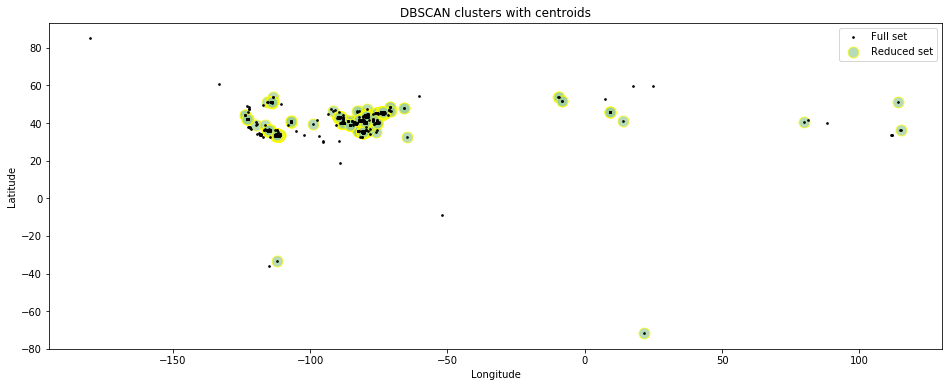

In [30]:
fig, ax = plt.subplots(figsize=[16, 6])
rs_scatter = ax.scatter(rep_points['longitude'], rep_points['latitude'], c='#99cc99', edgecolor='#ffff00', alpha=0.7, s=120)
df_scatter = ax.scatter(df_business_data['longitude'], df_business_data['latitude'], c='k', alpha=0.9, s=3)
ax.set_title('DBSCAN clusters with centroids')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()